# Tequila Chemistry Basics

Here we show the basics of the tequila chemistry module.  
In order for this to work you need to have psi4 installed in the same python environment as tequila.  
If you are in a conda environment installing psi4 is easy:
`conda install psi4 -c psi4`  
But better check the psi4 website for up to date instructions.

In some cases problems with the environment where enountered which are suspected to originate from conflicts between psi4 and tequila dependcies. Usually the safest way is to install psi4 **first** and then install tequila

Basic functionality is currently also provided with PySCF which might be easier to install. 

At the moment we only support closed-shell molecules

**There might be issues with psi4 and jupyter, currently the workarround is to reload the kernel before a cell gets executed, or run as a regular python script**

In [1]:
import tequila as tq

## Initialize Molecules

Molecules can be initialized by passing their geometries as string or the name of a `xyz` file.

In [2]:
import tequila as tq
molecule = tq.chemistry.Molecule(geometry = "H 0.0 0.0 0.0\nLi 0.0 0.0 1.6", basis_set="sto-3g")
print(molecule)

# lets also print some information about the orbitals
# we need it later

print("The Orbitals are:")
for orbital in molecule.orbitals:
    print(orbital)

<class 'tequila.quantumchemistry.psi4_interface.QuantumChemistryPsi4'>
basis_set       : sto-3g          
geometry        : H 0.0 0.0 0.0
Li 0.0 0.0 1.6 
description     :                 
multiplicity    : 1               
charge          : 0               
closed_shell    : True            
name            : molecule        

Psi4 Data
Point Group (full) : c_inf_v         
Point Group (used) : c2v             
nirrep          : 4 
irreps          : ['A1', 'A2', 'B1', 'B2'] 
mos per irrep   : [4, 0, 1, 1]    

The Orbitals are:
0 : 0A1 energy = -2.348839 
1 : 1A1 energy = -0.285276 
2 : 2A1 energy = +0.078216 
3 : 0B1 energy = +0.163950 
4 : 0B2 energy = +0.163950 
5 : 3A1 energy = +0.547769 


You can initialize a tequila `QubitHamiltonian` from a molecule with `make_hamiltonian`.
The standard transformation is the `jordan-wigner` transformation.  
You can use other transformations by initializing the molecule with the `transformation` keyword.

In [3]:
import tequila as tq
H = molecule.make_hamiltonian()
# the LiH Hamiltonian is already quite large, better not print the full thing
print("Hamiltonian has {} terms".format(len(H)))

Hamiltonian has 631 terms


In [4]:
molecule = tq.chemistry.Molecule(geometry = "H 0.0 0.0 0.0\nLi 0.0 0.0 1.6", basis_set="sto-3g", transformation="bravyi-kitaev")
H = molecule.make_hamiltonian()
print("Hamiltonian has {} terms".format(len(H)))

Hamiltonian has 631 terms


## Setting active spaces

You can define active spaces on your molcule by passing down a dictionary of active orbitals.  
The orbitals are grouped into the irreducible representation of the underlying symmetry group (see the printout of `print(molecule)` above).

Lets take the LiH molecule from above but initialize it with an active space containing the second two A1 orbitals (meaning the first 0A1 orbital is frozen) and the B1 orbital

In [5]:
import tequila as tq
active_orbitals = {"A1":[1,2], "B1":[0]}
molecule = tq.chemistry.Molecule(geometry = "H 0.0 0.0 0.0\nLi 0.0 0.0 1.6", basis_set="sto-3g", active_orbitals=active_orbitals)
H = molecule.make_hamiltonian()
print("Hamiltonian has {} terms".format(len(H)))

There are known issues with some psi4 methods and frozen virtual orbitals. Proceed with fingers crossed for hf.
Hamiltonian has 62 terms


Lets make the active space even smaller, so that we can print out stuff in this tutorial

In [6]:
import tequila as tq
active_orbitals = {"A1":[1], "B1":[0]}
molecule = tq.chemistry.Molecule(geometry = "H 0.0 0.0 0.0\nLi 0.0 0.0 1.6", basis_set="sto-3g", active_orbitals=active_orbitals)
H = molecule.make_hamiltonian()
print("Hamiltonian has {} terms".format(len(H)))
print(H)

There are known issues with some psi4 methods and frozen virtual orbitals. Proceed with fingers crossed for hf.
Hamiltonian has 15 terms
-7.4711+0.1352Z(0)+0.1352Z(1)-0.0310Z(2)-0.0310Z(3)+0.1218Z(0)Z(1)+0.0059Y(0)X(1)X(2)Y(3)-0.0059Y(0)Y(1)X(2)X(3)-0.0059X(0)X(1)Y(2)Y(3)+0.0059X(0)Y(1)Y(2)X(3)+0.0617Z(0)Z(2)+0.0675Z(0)Z(3)+0.0675Z(1)Z(2)+0.0617Z(1)Z(3)+0.0782Z(2)Z(3)


## Computing classical methods with Psi4

We can use psi4 to compute the energies (and sometimes other quantities) with the `compute_energy` function.
Here are some examples. Note that the energies are computed within the active space if one is set.

Note also that not all active spaces can be represented by psi4 which will mean you can/should not use the classical psi4 methods with those (a warning will be printed). You will still get the right active space hamiltonian however.

Active spaces which will not work for psi4 methds are the ones where the orbitals of individual irreps are not in one block ( e.g. {`"A1":[1,3]`} )

In [1]:
# YOU MIGHT HAVE TO RESTART THE JUPYTER KERNEL
import tequila as tq
active_orbitals = {"A1":[1], "B1":[0], "B2":[0]}
molecule = tq.chemistry.Molecule(geometry = "H 0.0 0.0 0.0\nLi 0.0 0.0 1.6", basis_set="sto-3g", active_orbitals=active_orbitals)

mp2 = molecule.compute_energy(method="mp2")

# Note there are known issues for some methods when the active space as frozen virtuals as is the case here
# detci based methods are fine again 
fci = molecule.compute_energy(method="fci")

# for most coupled-cluster like models you can compute amplitudes
# Amplitudes are computed in c1 and in the full space, this is why the active space troubles from above usually don't hold
# Note that amplitudes are in closed-shell
amplitudes = molecule.compute_amplitudes("mp2")

# you can export a parameter dictionary which holds the indices of the amplitude as keys and values as values
# for this small active space that is only one amplitude for mp2
variables = amplitudes.make_parameter_dictionary()
print(variables)

# similar for ccsd since the singles are 0 due to symmetry (that changes if you change the active space)
amplitudes = molecule.compute_amplitudes("ccsd")
variables = amplitudes.make_parameter_dictionary()
print(variables)

There are known issues with some psi4 methods and frozen virtual orbitals. Proceed with fingers crossed for hf.
There are known issues with some psi4 methods and frozen virtual orbitals. Proceed with fingers crossed for mp2.
There are known issues with some psi4 methods and frozen virtual orbitals. Proceed with fingers crossed for fci.
{(1, 0, 1, 0): -0.026069395810974536, (2, 0, 2, 0): -0.026069395810972836}
{(1, 0, 1, 0): -0.027418022914682542, (2, 0, 2, 0): -0.027418022914682535}


## Hello World "H2" optimization with LiH in an active space

Lets do a small hand-constructed VQE like it would be done for the Hydrogen molecule in STO-3G, just that we use our active space LiH molecule from the cell above.
For consistency reasons we initialize everything again.  

Check the `BasicUsage` and `SciPyOptimizers` tutorial notebooks for more information about then

In [2]:
import tequila as tq
# define the active space
active_orbitals = {"A1":[1], "B1":[0]}

# define the molecule
molecule = tq.chemistry.Molecule(geometry = "H 0.0 0.0 0.0\nLi 0.0 0.0 1.6", basis_set="sto-3g", active_orbitals=active_orbitals)

# make the hamiltonian
H = molecule.make_hamiltonian()

# define a hand designed circuit
U = tq.gates.Ry(angle="a", target=0) + tq.gates.X(target=[2,3])
U += tq.gates.X(target=1, control=0)
U += tq.gates.X(target=2, control=0)
U += tq.gates.X(target=3, control=1)

# define the expectationvalue
E = tq.ExpectationValue(H=H, U=U)

# optimize
result = tq.minimize(objective=E, method="BFGS", initial_values={k:0.0 for k in E.extract_variables()})

# compute a reference value with psi4
fci = molecule.compute_energy(method="fci")

print("VQE : {:+2.8}f".format(result.energy))
print("FCI : {:+2.8}f".format(fci))


There are known issues with some psi4 methods and frozen virtual orbitals. Proceed with fingers crossed for hf.
Optimizer: <class 'tequila.optimizers.optimizer_scipy.OptimizerSciPy'> 
backend         : None
backend_options : {}
samples         : None
save_history    : True
noise           : None

Method          : BFGS
Objective       : 1 expectationvalues
gradient        : 2 expectationvalues

active variables : 1

E=-7.19702401  angles= {a: 0.0}  samples= None
E=-7.19766373  angles= {a: -0.0234220027923584}  samples= None
E=-7.20203763  angles= {a: -0.11711001396179199}  samples= None
E=-7.24749228  angles= {a: -0.49186205863952637}  samples= None
E=-7.68640044  angles= {a: -1.9908702373504639}  samples= None
E=-7.59671569  angles= {a: -7.986902952194214}  samples= None
E=-7.86212174  angles= {a: -3.129600457337474}  samples= None
E=-7.59889693  angles= {a: -1.7104055550334691}  samples= None
E=-7.86268191  angles= {a: -3.0777237637496633}  samples= None
E=-7.86268890  angles= {a: -3

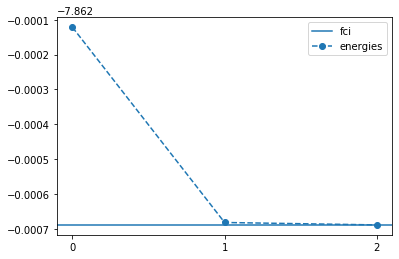

In [3]:
# some more information from the optimization
result.history.plot("energies", baselines={"fci":fci})

## Unitary Coupled-Cluster Style Construction

Here we show how to initialize in the style of unitary coupled-cluster.  
In this example we are gonna compute the `mp2` amplitudes and build a UCC type circuit from them.  
Here we use the cc2 amplitudes only to define an order on the trotterized gates and remove small amplitudes as classical prescreening.

We use again an active space to make the computation fast.

First we start with the manual construction and then show how to use in build convenience functions of tequila to.

An important function is the `make_excitation_generator` function of the molecule.  
This initializes a `QubitHamiltonian` which can be used to define a unitary gate which acts as excitation operation of electrons.

$$\displaystyle
U(\theta) = e^{-i\frac{\theta}{2} G_{iajbkc\dots}}
$$

In fermionic language the generator is defined as

$$
G_{ia,jb,jc,\dots} =  i ( a^\dagger_a a_i a^\dagger_b a_j a^\dagger_c a_k \dots - h.c. )
$$

The `make_excitation_generator` function gives back this generator in the qubit representation (depends on the chosen `transformation` of the molecule) and takes the indices as list of tuples  
  
$$
\text{make_excitation_generator(indices=[(a,i),(b,j),...])} = G_{ia,jb,jc,\dots}
$$

### Manual Construction

In [1]:
# YOU MIGHT HAVE TO RESTART THE JUPYTER KERNEL
import tequila as tq
threshold = 1.e-6

# define the active space
active_orbitals = {"A1":[1], "B1":[0]}

# define the molecule
molecule = tq.chemistry.Molecule(geometry = "H 0.0 0.0 0.0\nLi 0.0 0.0 1.6", basis_set="sto-3g", active_orbitals=active_orbitals)

# make the hamiltonian
H = molecule.make_hamiltonian()

# compute classical amplitudes
amplitudes = molecule.compute_amplitudes(method="mp2")

# in this example there is only one closed-shell MP2 amplitude, therefore manual construction is reasonable in this tutorial
# first we make a dictionary out of the non-zero MP2 amplitudes
ampdict = amplitudes.make_parameter_dictionary(threshold=threshold)
print(ampdict)
# lets get the indices of the only amplitude which is there manually
indices = list(ampdict.keys())[0]

# the (1, 0, 1, 0) index in closed shell leads to the (2, 0, 3, 1) and (3, 1, 2, 0) excitations on the qubits
# but first we need to initialize the hartree fock state
U = molecule.prepare_reference()

# now add the two 2-electron excitations 
# for this we define the generators and build trotterized gates with them
# note that the two generators are actually the same
# we sum them up since we want to parametrize them with the same variable which we will call "a"
generator = molecule.make_excitation_generator(indices=[(3, 1),(2, 0)]) + molecule.make_excitation_generator(indices=[(3, 1),(2, 0)])
U += tq.gates.Trotterized(generators=[generator], angles=["a"], steps=1)

# define the expectationvalue
E = tq.ExpectationValue(H=H, U=U)

# optimize
result = tq.minimize(objective=E, method="BFGS", initial_values={k:0.0 for k in E.extract_variables()})

# compute a reference value with psi4
fci = molecule.compute_energy(method="fci")
print("VQE : {:+2.8}f".format(result.energy))
print("FCI : {:+2.8}f".format(fci))



There are known issues with some psi4 methods and frozen virtual orbitals. Proceed with fingers crossed for hf.
{(1, 0, 1, 0): -0.026069395810974536}
ObjectiveType is <class 'tequila.objective.objective.Objective'>
Starting BFGS optimization
Objective: 1 expectationvalues
Gradients: 16 expectationvalues (min=16, max=16)
Hessian: None

backend: <class 'tequila.simulators.simulator_qulacs.BackendExpectationValueQulacs'>
samples: None
1 active variables
E= -7.861864768775314  angles= {a: 0.0}  samples= None
E= -7.862598093888593  angles= {a: -0.0468440055847168}  samples= None
E= -7.862688897514223  angles= {a: -0.03516504106977361}  samples= None
Optimization terminated successfully.
         Current function value: -7.862689
         Iterations: 2
         Function evaluations: 3
         Gradient evaluations: 3
There are known issues with some psi4 methods and frozen virtual orbitals. Proceed with fingers crossed for fci.
VQE : -7.8626889f
FCI : -7.8626889f


### Automatic Construction

In [1]:
# YOU MIGHT HAVE TO RESTART THE JUPYTER KERNEL
import tequila as tq
threshold = 1.e-6

# define the active space
active_orbitals = {"A1":[1], "B1":[0]}

# define the molecule
molecule = tq.chemistry.Molecule(geometry = "H 0.0 0.0 0.0\nLi 0.0 0.0 1.6", basis_set="sto-3g", active_orbitals=active_orbitals)

# make the hamiltonian
H = molecule.make_hamiltonian()

# make the UCCSD ansatz (note that this will be without singles since it starts from mp2)
U = molecule.make_uccsd_ansatz(initial_amplitudes="mp2", threshold=threshold, trotter_steps=1)

# define the expectationvalue
E = tq.ExpectationValue(H=H, U=U)

# optimize
result = tq.minimize(objective=E, method="BFGS", initial_values={k:0.0 for k in E.extract_variables()})

# compute a reference value with psi4
fci = molecule.compute_energy(method="fci")

print("VQE : {:+2.8}f".format(result.energy))
print("FCI : {:+2.8}f".format(fci))
    
    

There are known issues with some psi4 methods and frozen virtual orbitals. Proceed with fingers crossed for hf.
ObjectiveType is <class 'tequila.objective.objective.Objective'>
Starting BFGS optimization
Objective: 1 expectationvalues
Gradients: 32 expectationvalues (min=32, max=32)
Hessian: None

backend: <class 'tequila.simulators.simulator_qulacs.BackendExpectationValueQulacs'>
samples: None
1 active variables
E= -7.861864768775314  angles= {(1, 0, 1, 0): 0.0}  samples= None
E= -7.862598093888588  angles= {(1, 0, 1, 0): -0.0468440055847168}  samples= None
E= -7.862688897514223  angles= {(1, 0, 1, 0): -0.03516504106977361}  samples= None
Optimization terminated successfully.
         Current function value: -7.862689
         Iterations: 2
         Function evaluations: 3
         Gradient evaluations: 3
There are known issues with some psi4 methods and frozen virtual orbitals. Proceed with fingers crossed for fci.
VQE : -7.8626889f
FCI : -7.8626889f


### Pi System of Benzene
Lets repeat the last cell with the pi system of the benzene molecule

In [2]:
# YOU MIGHT HAVE TO RESTART THE JUPYTER KERNEL
import tequila as tq
threshold = 1.e-6
active = {"B1u": [0], "B3g": [0, 1], "B2g": [0], "Au": [0], "b1u": [1]}
molecule = tq.quantumchemistry.Molecule(geometry="data/benzene.xyz", basis_set='sto-3g', active_orbitals=active)
H = molecule.make_hamiltonian()

# make the UCCSD ansatz
U = molecule.make_uccsd_ansatz(initial_amplitudes="cc2", threshold=threshold, trotter_steps=1)

# define the expectationvalue
E = tq.ExpectationValue(H=H, U=U)

# compute reference energies
fci = molecule.compute_energy("fci")
cisd = molecule.compute_energy("detci", options={"detci__ex_level": 2})

# optimize
result = tq.minimize(objective=E, method="BFGS", gradient="2-point", method_options={"eps":1.e-3, "gtol": 1.e-2}, initial_values={k:0.0 for k in E.extract_variables()})

print("VQE : {:+2.8}f".format(result.energy))
print("CISD: {:+2.8}f".format(cisd))
print("FCI : {:+2.8}f".format(fci))

There are known issues with some psi4 methods and frozen virtual orbitals. Proceed with fingers crossed for hf.
There are known issues with some psi4 methods and frozen virtual orbitals. Proceed with fingers crossed for fci.
There are known issues with some psi4 methods and frozen virtual orbitals. Proceed with fingers crossed for detci.
ObjectiveType is <class 'tequila.objective.objective.Objective'>
Starting BFGS optimization
Objective: 1 expectationvalues
Gradients: 2-point
Hessian: None

backend: <class 'tequila.simulators.simulator_qulacs.BackendExpectationValueQulacs'>
samples: None
22 active variables
E= -227.88792153297504  angles= {(3, 0, 5, 2): 0.0, (3, 2, 5, 0): 0.0, (5, 2, 5, 2): 0.0, (4, 2, 3, 1): 0.0, (4, 0): 0.0, (5, 0, 5, 0): 0.0, (3, 1, 3, 1): 0.0, (3, 1, 4, 2): 0.0, (4, 1, 5, 0): 0.0, (3, 2, 4, 1): 0.0, (5, 1, 4, 0): 0.0, (5, 0, 4, 1): 0.0, (5, 0, 3, 2): 0.0, (4, 0, 4, 0): 0.0, (5, 2, 3, 0): 0.0, (4, 1, 4, 1): 0.0, (4, 2, 4, 2): 0.0, (3, 2, 3, 2): 0.0, (4, 1, 3, 2): 0

E= -227.88772699368133  angles= {(3, 0, 5, 2): 0.0, (3, 2, 5, 0): 0.0, (5, 2, 5, 2): 0.0, (4, 2, 3, 1): 0.0, (4, 0): 0.0, (5, 0, 5, 0): 0.0, (3, 1, 3, 1): 0.0, (3, 1, 4, 2): 0.0, (4, 1, 5, 0): 0.0, (3, 2, 4, 1): 0.0, (5, 1, 4, 0): 0.0, (5, 0, 4, 1): 0.0, (5, 0, 3, 2): 0.0, (4, 0, 4, 0): 0.0, (5, 2, 3, 0): 0.0, (4, 1, 4, 1): 0.001, (4, 2, 4, 2): 0.0, (3, 2, 3, 2): 0.0, (4, 1, 3, 2): 0.0, (3, 0, 3, 0): 0.0, (5, 1, 5, 1): 0.0, (4, 0, 5, 1): 0.0}  samples= None
E= -227.88781001304642  angles= {(3, 0, 5, 2): 0.0, (3, 2, 5, 0): 0.0, (5, 2, 5, 2): 0.0, (4, 2, 3, 1): 0.0, (4, 0): 0.0, (5, 0, 5, 0): 0.0, (3, 1, 3, 1): 0.0, (3, 1, 4, 2): 0.0, (4, 1, 5, 0): 0.0, (3, 2, 4, 1): 0.0, (5, 1, 4, 0): 0.0, (5, 0, 4, 1): 0.0, (5, 0, 3, 2): 0.0, (4, 0, 4, 0): 0.0, (5, 2, 3, 0): 0.0, (4, 1, 4, 1): 0.0, (4, 2, 4, 2): 0.001, (3, 2, 3, 2): 0.0, (4, 1, 3, 2): 0.0, (3, 0, 3, 0): 0.0, (5, 1, 5, 1): 0.0, (4, 0, 5, 1): 0.0}  samples= None
E= -227.8877269810726  angles= {(3, 0, 5, 2): 0.0, (3, 2, 5, 0): 0.0, (5, 2,

E= -226.9866615719647  angles= {(3, 0, 5, 2): 0.1572695008746905, (3, 2, 5, 0): 0.03545315459518861, (5, 2, 5, 2): -0.11507814411970685, (4, 2, 3, 1): 0.3530088013974364, (4, 0): -0.0002797510205709841, (5, 0, 5, 0): -0.08711814404907636, (3, 1, 3, 1): -0.11151888708127444, (3, 1, 4, 2): 0.3530088013974364, (4, 1, 5, 0): -0.04039760713681062, (3, 2, 4, 1): -0.2734920682314623, (5, 1, 4, 0): -0.16205490697984715, (5, 0, 4, 1): -0.04039760713681062, (5, 0, 3, 2): 0.03545315459518861, (4, 0, 4, 0): -0.11265558811146548, (5, 2, 3, 0): 0.1572695008746905, (4, 1, 4, 1): -0.19453929371593404, (4, 2, 4, 2): -0.11151992862323823, (3, 2, 3, 2): -0.19455190243888865, (4, 1, 3, 2): -0.2734920682314623, (3, 0, 3, 0): -0.11265259740866895, (5, 1, 5, 1): -0.11507963489520989, (4, 0, 5, 1): -0.16205490697984715}  samples= None
E= -226.98653821418804  angles= {(3, 0, 5, 2): 0.1572695008746905, (3, 2, 5, 0): 0.03545315459518861, (5, 2, 5, 2): -0.11507814411970685, (4, 2, 3, 1): 0.3530088013974364, (4, 0

E= -226.98622767253497  angles= {(3, 0, 5, 2): 0.1572695008746905, (3, 2, 5, 0): 0.03545315459518861, (5, 2, 5, 2): -0.11507814411970685, (4, 2, 3, 1): 0.3530088013974364, (4, 0): -0.0002797510205709841, (5, 0, 5, 0): -0.08811814404907636, (3, 1, 3, 1): -0.11151888708127444, (3, 1, 4, 2): 0.3530088013974364, (4, 1, 5, 0): -0.04039760713681062, (3, 2, 4, 1): -0.2734920682314623, (5, 1, 4, 0): -0.16205490697984715, (5, 0, 4, 1): -0.04039760713681062, (5, 0, 3, 2): 0.03545315459518861, (4, 0, 4, 0): -0.11265558811146548, (5, 2, 3, 0): 0.1572695008746905, (4, 1, 4, 1): -0.19353929371593404, (4, 2, 4, 2): -0.11151992862323823, (3, 2, 3, 2): -0.19455190243888865, (4, 1, 3, 2): -0.2734920682314623, (3, 0, 3, 0): -0.11265259740866895, (5, 1, 5, 1): -0.11507963489520989, (4, 0, 5, 1): -0.16205490697984715}  samples= None
E= -226.98653725410765  angles= {(3, 0, 5, 2): 0.1572695008746905, (3, 2, 5, 0): 0.03545315459518861, (5, 2, 5, 2): -0.11507814411970685, (4, 2, 3, 1): 0.3530088013974364, (4, 

E= -227.9245650357023  angles= {(3, 0, 5, 2): 0.01603861798715112, (3, 2, 5, 0): 0.004615574538159864, (5, 2, 5, 2): -0.011735869840884884, (4, 2, 3, 1): 0.036000453236173104, (4, 0): -2.852949698129128e-05, (5, 0, 5, 0): -0.008986442013737782, (3, 1, 3, 1): -0.0113728906005363, (3, 1, 4, 2): 0.036000453236173104, (4, 1, 5, 0): -0.004119818431792237, (3, 2, 4, 1): -0.027891198105698352, (5, 1, 4, 0): -0.016526642047805715, (5, 0, 4, 1): -0.004119818431792237, (5, 0, 3, 2): 0.0036155745381598638, (4, 0, 4, 0): -0.011488813354073625, (5, 2, 3, 0): 0.01603861798715112, (4, 1, 4, 1): -0.01983945646197559, (4, 2, 4, 2): -0.011372996818802281, (3, 2, 3, 2): -0.019840742321532913, (4, 1, 3, 2): -0.027891198105698352, (3, 0, 3, 0): -0.011488508356986461, (5, 1, 5, 1): -0.011736021872770692, (4, 0, 5, 1): -0.016526642047805715}  samples= None
E= -227.924381208266  angles= {(3, 0, 5, 2): 0.01603861798715112, (3, 2, 5, 0): 0.0036155745381598638, (5, 2, 5, 2): -0.010735869840884885, (4, 2, 3, 1): 

E= -227.92434870224957  angles= {(3, 0, 5, 2): 0.01603861798715112, (3, 2, 5, 0): 0.0036155745381598638, (5, 2, 5, 2): -0.011735869840884884, (4, 2, 3, 1): 0.036000453236173104, (4, 0): -2.852949698129128e-05, (5, 0, 5, 0): -0.008986442013737782, (3, 1, 3, 1): -0.0113728906005363, (3, 1, 4, 2): 0.036000453236173104, (4, 1, 5, 0): -0.004119818431792237, (3, 2, 4, 1): -0.027891198105698352, (5, 1, 4, 0): -0.016526642047805715, (5, 0, 4, 1): -0.0031198184317922373, (5, 0, 3, 2): 0.0036155745381598638, (4, 0, 4, 0): -0.011488813354073625, (5, 2, 3, 0): 0.01603861798715112, (4, 1, 4, 1): -0.01983945646197559, (4, 2, 4, 2): -0.011372996818802281, (3, 2, 3, 2): -0.019840742321532913, (4, 1, 3, 2): -0.027891198105698352, (3, 0, 3, 0): -0.011488508356986461, (5, 1, 5, 1): -0.011736021872770692, (4, 0, 5, 1): -0.016526642047805715}  samples= None
E= -227.92456509920004  angles= {(3, 0, 5, 2): 0.01603861798715112, (3, 2, 5, 0): 0.0036155745381598638, (5, 2, 5, 2): -0.011735869840884884, (4, 2, 3,

E= -227.9243828460232  angles= {(3, 0, 5, 2): 0.01603861798715112, (3, 2, 5, 0): 0.0036155745381598638, (5, 2, 5, 2): -0.011735869840884884, (4, 2, 3, 1): 0.036000453236173104, (4, 0): -2.852949698129128e-05, (5, 0, 5, 0): -0.008986442013737782, (3, 1, 3, 1): -0.0113728906005363, (3, 1, 4, 2): 0.036000453236173104, (4, 1, 5, 0): -0.004119818431792237, (3, 2, 4, 1): -0.027891198105698352, (5, 1, 4, 0): -0.016526642047805715, (5, 0, 4, 1): -0.004119818431792237, (5, 0, 3, 2): 0.0036155745381598638, (4, 0, 4, 0): -0.011488813354073625, (5, 2, 3, 0): 0.01603861798715112, (4, 1, 4, 1): -0.01983945646197559, (4, 2, 4, 2): -0.011372996818802281, (3, 2, 3, 2): -0.019840742321532913, (4, 1, 3, 2): -0.027891198105698352, (3, 0, 3, 0): -0.011488508356986461, (5, 1, 5, 1): -0.011736021872770692, (4, 0, 5, 1): -0.015526642047805714}  samples= None
E= -227.97587220303487  angles= {(3, 0, 5, 2): 0.051877338079571386, (3, 2, 5, 0): 0.0386809051550189, (5, 2, 5, 2): -0.045489171043952316, (4, 2, 3, 1):

E= -227.97589096398062  angles= {(3, 0, 5, 2): 0.051877338079571386, (3, 2, 5, 0): 0.0386809051550189, (5, 2, 5, 2): -0.045489171043952316, (4, 2, 3, 1): 0.05021427892739039, (4, 0): -0.000132904562702201, (5, 0, 5, 0): -0.0407435032477811, (3, 1, 3, 1): -0.037925286456508965, (3, 1, 4, 2): 0.051142163888255626, (4, 1, 5, 0): -0.04081980392353845, (3, 2, 4, 1): -0.0008386088492389823, (5, 1, 4, 0): -0.05406258219046188, (5, 0, 4, 1): -0.04084255456962303, (5, 0, 3, 2): 0.03869995431893994, (4, 0, 4, 0): -0.04547242396345431, (5, 2, 3, 0): 0.051885002362308086, (4, 1, 4, 1): -0.08910042104926745, (4, 2, 4, 2): -0.037925241038264765, (3, 2, 3, 2): -0.08887250464769877, (4, 1, 3, 2): -0.0009681743075858167, (3, 0, 3, 0): -0.045355230607750256, (5, 1, 5, 1): -0.04559392120608151, (4, 0, 5, 1): -0.05405492593963401}  samples= None
E= -227.97582040830494  angles= {(3, 0, 5, 2): 0.051877338079571386, (3, 2, 5, 0): 0.0386809051550189, (5, 2, 5, 2): -0.045489171043952316, (4, 2, 3, 1): 0.050214

E= -227.97577713850043  angles= {(3, 0, 5, 2): 0.051877338079571386, (3, 2, 5, 0): 0.0386809051550189, (5, 2, 5, 2): -0.045489171043952316, (4, 2, 3, 1): 0.05021427892739039, (4, 0): -0.000132904562702201, (5, 0, 5, 0): -0.0407435032477811, (3, 1, 3, 1): -0.037925286456508965, (3, 1, 4, 2): 0.050142163888255625, (4, 1, 5, 0): -0.04081980392353845, (3, 2, 4, 1): -0.0008386088492389823, (5, 1, 4, 0): -0.05406258219046188, (5, 0, 4, 1): -0.04084255456962303, (5, 0, 3, 2): 0.03869995431893994, (4, 0, 4, 0): -0.04547242396345431, (5, 2, 3, 0): 0.051885002362308086, (4, 1, 4, 1): -0.08910042104926745, (4, 2, 4, 2): -0.037925241038264765, (3, 2, 3, 2): -0.08787250464769877, (4, 1, 3, 2): -0.0009681743075858167, (3, 0, 3, 0): -0.045355230607750256, (5, 1, 5, 1): -0.04559392120608151, (4, 0, 5, 1): -0.05405492593963401}  samples= None
E= -227.97595048199537  angles= {(3, 0, 5, 2): 0.051877338079571386, (3, 2, 5, 0): 0.0386809051550189, (5, 2, 5, 2): -0.045489171043952316, (4, 2, 3, 1): 0.050214

E= -227.96746718200362  angles= {(3, 0, 5, 2): 0.0776913736055518, (3, 2, 5, 0): 0.0914223774258226, (5, 2, 5, 2): -0.022574592769602254, (4, 2, 3, 1): 0.12419352103584332, (4, 0): -0.0003856555883258653, (5, 0, 5, 0): -0.04545872592527786, (3, 1, 3, 1): -0.028368654878924572, (3, 1, 4, 2): 0.12333663129818279, (4, 1, 5, 0): -0.09527147474564385, (3, 2, 4, 1): 0.05748924228708419, (5, 1, 4, 0): -0.07146644978248112, (5, 0, 4, 1): -0.09554846958958009, (5, 0, 3, 2): 0.0916368322465495, (4, 0, 4, 0): -0.03967783167938211, (5, 2, 3, 0): 0.07790739891968719, (4, 1, 4, 1): -0.21084907029737138, (4, 2, 4, 2): -0.028385200726444425, (3, 2, 3, 2): -0.2064486355184652, (4, 1, 3, 2): 0.05659777093591835, (3, 0, 3, 0): -0.036751700263362816, (5, 1, 5, 1): -0.025060495308395166, (4, 0, 5, 1): -0.07128994159333249}  samples= None
E= -227.9675867891187  angles= {(3, 0, 5, 2): 0.0776913736055518, (3, 2, 5, 0): 0.0914223774258226, (5, 2, 5, 2): -0.022574592769602254, (4, 2, 3, 1): 0.12319352103584331,

E= -227.9675548889321  angles= {(3, 0, 5, 2): 0.0776913736055518, (3, 2, 5, 0): 0.0914223774258226, (5, 2, 5, 2): -0.022574592769602254, (4, 2, 3, 1): 0.12319352103584331, (4, 0): -0.0003856555883258653, (5, 0, 5, 0): -0.04545872592527786, (3, 1, 3, 1): -0.028368654878924572, (3, 1, 4, 2): 0.12333663129818279, (4, 1, 5, 0): -0.09527147474564385, (3, 2, 4, 1): 0.05748924228708419, (5, 1, 4, 0): -0.07146644978248112, (5, 0, 4, 1): -0.09554846958958009, (5, 0, 3, 2): 0.0916368322465495, (4, 0, 4, 0): -0.03867783167938211, (5, 2, 3, 0): 0.07790739891968719, (4, 1, 4, 1): -0.21084907029737138, (4, 2, 4, 2): -0.028385200726444425, (3, 2, 3, 2): -0.2064486355184652, (4, 1, 3, 2): 0.05659777093591835, (3, 0, 3, 0): -0.036751700263362816, (5, 1, 5, 1): -0.025060495308395166, (4, 0, 5, 1): -0.07128994159333249}  samples= None
E= -227.96781549096667  angles= {(3, 0, 5, 2): 0.0776913736055518, (3, 2, 5, 0): 0.0914223774258226, (5, 2, 5, 2): -0.022574592769602254, (4, 2, 3, 1): 0.12319352103584331,

E= -227.9861033246339  angles= {(3, 0, 5, 2): 0.06284546042684924, (3, 2, 5, 0): 0.06109022275511028, (5, 2, 5, 2): -0.035752998728066386, (4, 2, 3, 1): 0.0812224200392874, (4, 0): -0.00024029591457549633, (5, 0, 5, 0): -0.04274695362536321, (3, 1, 3, 1): -0.033864770452906555, (3, 1, 4, 2): 0.0812417520517546, (4, 1, 5, 0): -0.06395576757360276, (3, 2, 4, 1): 0.023944304572923607, (5, 1, 4, 0): -0.06145730932922997, (5, 0, 4, 1): -0.06408654400532306, (5, 0, 3, 2): 0.061192297804272704, (4, 0, 4, 0): -0.04301036036784445, (5, 2, 3, 0): 0.06294165520232838, (4, 1, 4, 1): -0.14083018950120363, (4, 2, 4, 2): -0.0338717744955114, (3, 2, 3, 2): -0.1388294122847173, (4, 1, 3, 2): 0.023491013014442595, (3, 0, 3, 0): -0.041699677668699475, (5, 1, 5, 1): -0.03686947642766154, (4, 0, 5, 1): -0.061377909599308604}  samples= None
E= -227.98621739139202  angles= {(3, 0, 5, 2): 0.06384546042684924, (3, 2, 5, 0): 0.06109022275511028, (5, 2, 5, 2): -0.035752998728066386, (4, 2, 3, 1): 0.0812224200392

E= -227.98619501390317  angles= {(3, 0, 5, 2): 0.06284546042684924, (3, 2, 5, 0): 0.06109022275511028, (5, 2, 5, 2): -0.035752998728066386, (4, 2, 3, 1): 0.0812224200392874, (4, 0): -0.00024029591457549633, (5, 0, 5, 0): -0.04274695362536321, (3, 1, 3, 1): -0.033864770452906555, (3, 1, 4, 2): 0.0812417520517546, (4, 1, 5, 0): -0.06395576757360276, (3, 2, 4, 1): 0.02494430457292361, (5, 1, 4, 0): -0.06145730932922997, (5, 0, 4, 1): -0.06408654400532306, (5, 0, 3, 2): 0.061192297804272704, (4, 0, 4, 0): -0.04301036036784445, (5, 2, 3, 0): 0.06294165520232838, (4, 1, 4, 1): -0.14083018950120363, (4, 2, 4, 2): -0.0338717744955114, (3, 2, 3, 2): -0.1388294122847173, (4, 1, 3, 2): 0.023491013014442595, (3, 0, 3, 0): -0.041699677668699475, (5, 1, 5, 1): -0.03686947642766154, (4, 0, 5, 1): -0.061377909599308604}  samples= None
E= -227.98594976874597  angles= {(3, 0, 5, 2): 0.06284546042684924, (3, 2, 5, 0): 0.06109022275511028, (5, 2, 5, 2): -0.035752998728066386, (4, 2, 3, 1): 0.0812224200392

E= -227.98608677044282  angles= {(3, 0, 5, 2): 0.06284546042684924, (3, 2, 5, 0): 0.06109022275511028, (5, 2, 5, 2): -0.035752998728066386, (4, 2, 3, 1): 0.0812224200392874, (4, 0): -0.00024029591457549633, (5, 0, 5, 0): -0.04274695362536321, (3, 1, 3, 1): -0.033864770452906555, (3, 1, 4, 2): 0.0812417520517546, (4, 1, 5, 0): -0.06395576757360276, (3, 2, 4, 1): 0.023944304572923607, (5, 1, 4, 0): -0.06145730932922997, (5, 0, 4, 1): -0.06408654400532306, (5, 0, 3, 2): 0.061192297804272704, (4, 0, 4, 0): -0.04301036036784445, (5, 2, 3, 0): 0.06294165520232838, (4, 1, 4, 1): -0.14083018950120363, (4, 2, 4, 2): -0.0338717744955114, (3, 2, 3, 2): -0.1388294122847173, (4, 1, 3, 2): 0.023491013014442595, (3, 0, 3, 0): -0.040699677668699474, (5, 1, 5, 1): -0.03686947642766154, (4, 0, 5, 1): -0.061377909599308604}  samples= None
E= -227.98608177675234  angles= {(3, 0, 5, 2): 0.06284546042684924, (3, 2, 5, 0): 0.06109022275511028, (5, 2, 5, 2): -0.035752998728066386, (4, 2, 3, 1): 0.081222420039

E= -227.99267383784994  angles= {(3, 0, 5, 2): 0.08918542682679594, (3, 2, 5, 0): 0.06822119056807638, (5, 2, 5, 2): -0.02560028274512046, (4, 2, 3, 1): 0.11014668785931246, (4, 0): -0.00033222201666236937, (5, 0, 5, 0): -0.04473264270466814, (3, 1, 3, 1): -0.02767741739915452, (3, 1, 4, 2): 0.11033403650519513, (4, 1, 5, 0): -0.0662508392950378, (3, 2, 4, 1): 0.05928743076081286, (5, 1, 4, 0): -0.08955450145387743, (5, 0, 4, 1): -0.06639747598000179, (5, 0, 3, 2): 0.0683350079921085, (4, 0, 4, 0): -0.04026302616345244, (5, 2, 3, 0): 0.08930879566898205, (4, 1, 4, 1): -0.1976753803340291, (4, 2, 4, 2): -0.027669771399958694, (3, 2, 3, 2): -0.19407694359716382, (4, 1, 3, 2): 0.05836723158967769, (3, 0, 3, 0): -0.03753450970182868, (5, 1, 5, 1): -0.027916091828173964, (4, 0, 5, 1): -0.08950675969097259}  samples= None
E= -227.9927204303077  angles= {(3, 0, 5, 2): 0.08918542682679594, (3, 2, 5, 0): 0.06822119056807638, (5, 2, 5, 2): -0.02560028274512046, (4, 2, 3, 1): 0.11014668785931246,

E= -227.99274072449728  angles= {(3, 0, 5, 2): 0.08918542682679594, (3, 2, 5, 0): 0.06822119056807638, (5, 2, 5, 2): -0.02560028274512046, (4, 2, 3, 1): 0.11014668785931246, (4, 0): -0.00033222201666236937, (5, 0, 5, 0): -0.04573264270466814, (3, 1, 3, 1): -0.02767741739915452, (3, 1, 4, 2): 0.11033403650519513, (4, 1, 5, 0): -0.0662508392950378, (3, 2, 4, 1): 0.05928743076081286, (5, 1, 4, 0): -0.08955450145387743, (5, 0, 4, 1): -0.06639747598000179, (5, 0, 3, 2): 0.0683350079921085, (4, 0, 4, 0): -0.04026302616345244, (5, 2, 3, 0): 0.08930879566898205, (4, 1, 4, 1): -0.1966753803340291, (4, 2, 4, 2): -0.027669771399958694, (3, 2, 3, 2): -0.19407694359716382, (4, 1, 3, 2): 0.05836723158967769, (3, 0, 3, 0): -0.03753450970182868, (5, 1, 5, 1): -0.027916091828173964, (4, 0, 5, 1): -0.08950675969097259}  samples= None
E= -227.9927206967925  angles= {(3, 0, 5, 2): 0.08918542682679594, (3, 2, 5, 0): 0.06822119056807638, (5, 2, 5, 2): -0.02560028274512046, (4, 2, 3, 1): 0.11014668785931246,

E= -227.99029200593682  angles= {(3, 0, 5, 2): 0.08093957133577796, (3, 2, 5, 0): 0.053131373711696316, (5, 2, 5, 2): -0.047472531752822275, (4, 2, 3, 1): 0.1126095929651439, (4, 0): -0.0015875148629696566, (5, 0, 5, 0): -0.08864083866039563, (3, 1, 3, 1): -0.03286760394983432, (3, 1, 4, 2): 0.11304430304964697, (4, 1, 5, 0): -0.06386710199775197, (3, 2, 4, 1): 0.06373661968663363, (5, 1, 4, 0): -0.07125011316162619, (5, 0, 4, 1): -0.06421103217386759, (5, 0, 3, 2): 0.05223022014271043, (4, 0, 4, 0): -0.04498757524144947, (5, 2, 3, 0): 0.08108787870011668, (4, 1, 4, 1): -0.19484814893058738, (4, 2, 4, 2): -0.03263127291081835, (3, 2, 3, 2): -0.19275266818823886, (4, 1, 3, 2): 0.06245385220058105, (3, 0, 3, 0): -0.046320006954124936, (5, 1, 5, 1): -0.04558343940795172, (4, 0, 5, 1): -0.07112775062053867}  samples= None
E= -227.99020810108854  angles= {(3, 0, 5, 2): 0.08093957133577796, (3, 2, 5, 0): 0.052131373711696315, (5, 2, 5, 2): -0.046472531752822274, (4, 2, 3, 1): 0.1126095929651

E= -227.9902349859507  angles= {(3, 0, 5, 2): 0.08093957133577796, (3, 2, 5, 0): 0.052131373711696315, (5, 2, 5, 2): -0.047472531752822275, (4, 2, 3, 1): 0.1126095929651439, (4, 0): -0.0015875148629696566, (5, 0, 5, 0): -0.08864083866039563, (3, 1, 3, 1): -0.03286760394983432, (3, 1, 4, 2): 0.11304430304964697, (4, 1, 5, 0): -0.06386710199775197, (3, 2, 4, 1): 0.06373661968663363, (5, 1, 4, 0): -0.07125011316162619, (5, 0, 4, 1): -0.06321103217386759, (5, 0, 3, 2): 0.05223022014271043, (4, 0, 4, 0): -0.04498757524144947, (5, 2, 3, 0): 0.08108787870011668, (4, 1, 4, 1): -0.19484814893058738, (4, 2, 4, 2): -0.03263127291081835, (3, 2, 3, 2): -0.19275266818823886, (4, 1, 3, 2): 0.06245385220058105, (3, 0, 3, 0): -0.046320006954124936, (5, 1, 5, 1): -0.04558343940795172, (4, 0, 5, 1): -0.07112775062053867}  samples= None
E= -227.99029282257945  angles= {(3, 0, 5, 2): 0.08093957133577796, (3, 2, 5, 0): 0.052131373711696315, (5, 2, 5, 2): -0.047472531752822275, (4, 2, 3, 1): 0.11260959296514

E= -227.99006713185182  angles= {(3, 0, 5, 2): 0.08093957133577796, (3, 2, 5, 0): 0.052131373711696315, (5, 2, 5, 2): -0.047472531752822275, (4, 2, 3, 1): 0.1126095929651439, (4, 0): -0.0015875148629696566, (5, 0, 5, 0): -0.08864083866039563, (3, 1, 3, 1): -0.03286760394983432, (3, 1, 4, 2): 0.11304430304964697, (4, 1, 5, 0): -0.06386710199775197, (3, 2, 4, 1): 0.06373661968663363, (5, 1, 4, 0): -0.07125011316162619, (5, 0, 4, 1): -0.06421103217386759, (5, 0, 3, 2): 0.05223022014271043, (4, 0, 4, 0): -0.04498757524144947, (5, 2, 3, 0): 0.08108787870011668, (4, 1, 4, 1): -0.19484814893058738, (4, 2, 4, 2): -0.03263127291081835, (3, 2, 3, 2): -0.19275266818823886, (4, 1, 3, 2): 0.06245385220058105, (3, 0, 3, 0): -0.046320006954124936, (5, 1, 5, 1): -0.04558343940795172, (4, 0, 5, 1): -0.07012775062053866}  samples= None
E= -227.99385655568  angles= {(3, 0, 5, 2): 0.08626490455943944, (3, 2, 5, 0): 0.06252248914674638, (5, 2, 5, 2): -0.03334700961096725, (4, 2, 3, 1): 0.11101900113375705,

E= -227.99385898294403  angles= {(3, 0, 5, 2): 0.08626490455943944, (3, 2, 5, 0): 0.06252248914674638, (5, 2, 5, 2): -0.03334700961096725, (4, 2, 3, 1): 0.11101900113375705, (4, 0): -0.000776822423944205, (5, 0, 5, 0): -0.06092989444856546, (3, 1, 3, 1): -0.029515680925541313, (3, 1, 4, 2): 0.1122939604090478, (4, 1, 5, 0): -0.06540656572465632, (3, 2, 4, 1): 0.060863247283875814, (5, 1, 4, 0): -0.08307144173301641, (5, 0, 4, 1): -0.06562307994200496, (5, 0, 3, 2): 0.06263100413508566, (4, 0, 4, 0): -0.04193636991784384, (5, 2, 3, 0): 0.08639710614303618, (4, 1, 4, 1): -0.19667402974309098, (4, 2, 4, 2): -0.029427039115573206, (3, 2, 3, 2): -0.19360791090260704, (4, 1, 3, 2): 0.0598146334396594, (3, 0, 3, 0): -0.0406461626265106, (5, 1, 5, 1): -0.03417352407011324, (4, 0, 5, 1): -0.08299727073611306}  samples= None
E= -227.9938490064351  angles= {(3, 0, 5, 2): 0.08626490455943944, (3, 2, 5, 0): 0.06252248914674638, (5, 2, 5, 2): -0.03334700961096725, (4, 2, 3, 1): 0.11101900113375705, 

E= -227.9938679664538  angles= {(3, 0, 5, 2): 0.08626490455943944, (3, 2, 5, 0): 0.06252248914674638, (5, 2, 5, 2): -0.03334700961096725, (4, 2, 3, 1): 0.11101900113375705, (4, 0): -0.000776822423944205, (5, 0, 5, 0): -0.06092989444856546, (3, 1, 3, 1): -0.029515680925541313, (3, 1, 4, 2): 0.11129396040904779, (4, 1, 5, 0): -0.06540656572465632, (3, 2, 4, 1): 0.060863247283875814, (5, 1, 4, 0): -0.08307144173301641, (5, 0, 4, 1): -0.06562307994200496, (5, 0, 3, 2): 0.06263100413508566, (4, 0, 4, 0): -0.04193636991784384, (5, 2, 3, 0): 0.08639710614303618, (4, 1, 4, 1): -0.19667402974309098, (4, 2, 4, 2): -0.029427039115573206, (3, 2, 3, 2): -0.19260791090260704, (4, 1, 3, 2): 0.0598146334396594, (3, 0, 3, 0): -0.0406461626265106, (5, 1, 5, 1): -0.03417352407011324, (4, 0, 5, 1): -0.08299727073611306}  samples= None
E= -227.99384545892286  angles= {(3, 0, 5, 2): 0.08626490455943944, (3, 2, 5, 0): 0.06252248914674638, (5, 2, 5, 2): -0.03334700961096725, (4, 2, 3, 1): 0.11101900113375705,

E= -227.99232011181394  angles= {(3, 0, 5, 2): 0.07267475962545768, (3, 2, 5, 0): 0.06630022371183894, (5, 2, 5, 2): -0.042302603552202174, (4, 2, 3, 1): 0.11107047237257543, (4, 0): -0.0010502319697256559, (5, 0, 5, 0): -0.07551595375558023, (3, 1, 3, 1): -0.03289771119042489, (3, 1, 4, 2): 0.11047287628619235, (4, 1, 5, 0): -0.057866965730982066, (3, 2, 4, 1): 0.05976914571781897, (5, 1, 4, 0): -0.08222347310488409, (5, 0, 4, 1): -0.05812906664938851, (5, 0, 3, 2): 0.0664895962603921, (4, 0, 4, 0): -0.044005592644717796, (5, 2, 3, 0): 0.0728944655023866, (4, 1, 4, 1): -0.18984822443594093, (4, 2, 4, 2): -0.03269383048496108, (3, 2, 3, 2): -0.188389749174341, (4, 1, 3, 2): 0.05855069812153956, (3, 0, 3, 0): -0.043396461306600416, (5, 1, 5, 1): -0.04250424913124314, (4, 0, 5, 1): -0.0821604181320272}  samples= None
E= -227.99232657615224  angles= {(3, 0, 5, 2): 0.07267475962545768, (3, 2, 5, 0): 0.06630022371183894, (5, 2, 5, 2): -0.042302603552202174, (4, 2, 3, 1): 0.11007047237257543

E= -227.9923405105895  angles= {(3, 0, 5, 2): 0.07267475962545768, (3, 2, 5, 0): 0.06630022371183894, (5, 2, 5, 2): -0.042302603552202174, (4, 2, 3, 1): 0.11007047237257543, (4, 0): -0.0010502319697256559, (5, 0, 5, 0): -0.07551595375558023, (3, 1, 3, 1): -0.03289771119042489, (3, 1, 4, 2): 0.11047287628619235, (4, 1, 5, 0): -0.057866965730982066, (3, 2, 4, 1): 0.05976914571781897, (5, 1, 4, 0): -0.08222347310488409, (5, 0, 4, 1): -0.05812906664938851, (5, 0, 3, 2): 0.0664895962603921, (4, 0, 4, 0): -0.043005592644717795, (5, 2, 3, 0): 0.0728944655023866, (4, 1, 4, 1): -0.18984822443594093, (4, 2, 4, 2): -0.03269383048496108, (3, 2, 3, 2): -0.188389749174341, (4, 1, 3, 2): 0.05855069812153956, (3, 0, 3, 0): -0.043396461306600416, (5, 1, 5, 1): -0.04250424913124314, (4, 0, 5, 1): -0.0821604181320272}  samples= None
E= -227.99242779080473  angles= {(3, 0, 5, 2): 0.07267475962545768, (3, 2, 5, 0): 0.06630022371183894, (5, 2, 5, 2): -0.042302603552202174, (4, 2, 3, 1): 0.11007047237257543,

E= -227.9941861284562  angles= {(3, 0, 5, 2): 0.08226169664672396, (3, 2, 5, 0): 0.06363528499819478, (5, 2, 5, 2): -0.03598503184713736, (4, 2, 3, 1): 0.1107395958838023, (4, 0): -0.0008573598473787002, (5, 0, 5, 0): -0.06522646584768084, (3, 1, 3, 1): -0.030511915357417853, (3, 1, 4, 2): 0.11105209614096327, (4, 1, 5, 0): -0.06318564854533208, (3, 2, 4, 1): 0.060540961092828555, (5, 1, 4, 0): -0.08282165817747936, (5, 0, 4, 1): -0.06341559109941118, (5, 0, 3, 2): 0.06376761795362884, (4, 0, 4, 0): -0.04254589460162258, (5, 2, 3, 0): 0.08241967410549832, (4, 1, 4, 1): -0.19466337290690722, (4, 2, 4, 2): -0.030389327974349383, (3, 2, 3, 2): -0.19207081277584678, (4, 1, 3, 2): 0.05944231983364288, (3, 0, 3, 0): -0.04145630979506185, (5, 1, 5, 1): -0.03662748056913354, (4, 0, 5, 1): -0.0827507615941777}  samples= None
E= -227.99417538692026  angles= {(3, 0, 5, 2): 0.08326169664672396, (3, 2, 5, 0): 0.06363528499819478, (5, 2, 5, 2): -0.03598503184713736, (4, 2, 3, 1): 0.1107395958838023,

E= -227.99417737177882  angles= {(3, 0, 5, 2): 0.08226169664672396, (3, 2, 5, 0): 0.06363528499819478, (5, 2, 5, 2): -0.03598503184713736, (4, 2, 3, 1): 0.1107395958838023, (4, 0): -0.0008573598473787002, (5, 0, 5, 0): -0.06522646584768084, (3, 1, 3, 1): -0.030511915357417853, (3, 1, 4, 2): 0.11105209614096327, (4, 1, 5, 0): -0.06318564854533208, (3, 2, 4, 1): 0.061540961092828556, (5, 1, 4, 0): -0.08282165817747936, (5, 0, 4, 1): -0.06341559109941118, (5, 0, 3, 2): 0.06376761795362884, (4, 0, 4, 0): -0.04254589460162258, (5, 2, 3, 0): 0.08241967410549832, (4, 1, 4, 1): -0.19466337290690722, (4, 2, 4, 2): -0.030389327974349383, (3, 2, 3, 2): -0.19207081277584678, (4, 1, 3, 2): 0.05944231983364288, (3, 0, 3, 0): -0.04145630979506185, (5, 1, 5, 1): -0.03662748056913354, (4, 0, 5, 1): -0.0827507615941777}  samples= None
E= -227.99421209458876  angles= {(3, 0, 5, 2): 0.08226169664672396, (3, 2, 5, 0): 0.06363528499819478, (5, 2, 5, 2): -0.03598503184713736, (4, 2, 3, 1): 0.1107395958838023

E= -227.9941882193362  angles= {(3, 0, 5, 2): 0.08226169664672396, (3, 2, 5, 0): 0.06363528499819478, (5, 2, 5, 2): -0.03598503184713736, (4, 2, 3, 1): 0.1107395958838023, (4, 0): -0.0008573598473787002, (5, 0, 5, 0): -0.06522646584768084, (3, 1, 3, 1): -0.030511915357417853, (3, 1, 4, 2): 0.11105209614096327, (4, 1, 5, 0): -0.06318564854533208, (3, 2, 4, 1): 0.060540961092828555, (5, 1, 4, 0): -0.08282165817747936, (5, 0, 4, 1): -0.06341559109941118, (5, 0, 3, 2): 0.06376761795362884, (4, 0, 4, 0): -0.04254589460162258, (5, 2, 3, 0): 0.08241967410549832, (4, 1, 4, 1): -0.19466337290690722, (4, 2, 4, 2): -0.030389327974349383, (3, 2, 3, 2): -0.19207081277584678, (4, 1, 3, 2): 0.05944231983364288, (3, 0, 3, 0): -0.04045630979506185, (5, 1, 5, 1): -0.03662748056913354, (4, 0, 5, 1): -0.0827507615941777}  samples= None
E= -227.99418628549472  angles= {(3, 0, 5, 2): 0.08226169664672396, (3, 2, 5, 0): 0.06363528499819478, (5, 2, 5, 2): -0.03598503184713736, (4, 2, 3, 1): 0.1107395958838023,

E= -227.99452127170875  angles= {(3, 0, 5, 2): 0.08110576794018057, (3, 2, 5, 0): 0.06438294041948706, (5, 2, 5, 2): -0.038858550155821424, (4, 2, 3, 1): 0.10609278918941935, (4, 0): -0.0010685399516014555, (5, 0, 5, 0): -0.059984058484202005, (3, 1, 3, 1): -0.03379426056578987, (3, 1, 4, 2): 0.1065249246826137, (4, 1, 5, 0): -0.06478962388355179, (3, 2, 4, 1): 0.05621671529852941, (5, 1, 4, 0): -0.08118352656877324, (5, 0, 4, 1): -0.06510517611973798, (5, 0, 3, 2): 0.0645517190201857, (4, 0, 4, 0): -0.0421153252153325, (5, 2, 3, 0): 0.08132107756539528, (4, 1, 4, 1): -0.18375398990498096, (4, 2, 4, 2): -0.03361154886191571, (3, 2, 3, 2): -0.18124269383439123, (4, 1, 3, 2): 0.054977640268141885, (3, 0, 3, 0): -0.04150005202241063, (5, 1, 5, 1): -0.03924248778890356, (4, 0, 5, 1): -0.08108917168708037}  samples= None
E= -227.99452092366684  angles= {(3, 0, 5, 2): 0.08110576794018057, (3, 2, 5, 0): 0.06438294041948706, (5, 2, 5, 2): -0.038858550155821424, (4, 2, 3, 1): 0.1060927891894193

E= -227.99452079590742  angles= {(3, 0, 5, 2): 0.08110576794018057, (3, 2, 5, 0): 0.06438294041948706, (5, 2, 5, 2): -0.038858550155821424, (4, 2, 3, 1): 0.10609278918941935, (4, 0): -0.0010685399516014555, (5, 0, 5, 0): -0.060984058484202006, (3, 1, 3, 1): -0.03379426056578987, (3, 1, 4, 2): 0.1065249246826137, (4, 1, 5, 0): -0.06478962388355179, (3, 2, 4, 1): 0.05621671529852941, (5, 1, 4, 0): -0.08118352656877324, (5, 0, 4, 1): -0.06510517611973798, (5, 0, 3, 2): 0.0645517190201857, (4, 0, 4, 0): -0.0421153252153325, (5, 2, 3, 0): 0.08132107756539528, (4, 1, 4, 1): -0.18275398990498096, (4, 2, 4, 2): -0.03361154886191571, (3, 2, 3, 2): -0.18124269383439123, (4, 1, 3, 2): 0.054977640268141885, (3, 0, 3, 0): -0.04150005202241063, (5, 1, 5, 1): -0.03924248778890356, (4, 0, 5, 1): -0.08108917168708037}  samples= None
E= -227.99452082492385  angles= {(3, 0, 5, 2): 0.08110576794018057, (3, 2, 5, 0): 0.06438294041948706, (5, 2, 5, 2): -0.038858550155821424, (4, 2, 3, 1): 0.1060927891894193

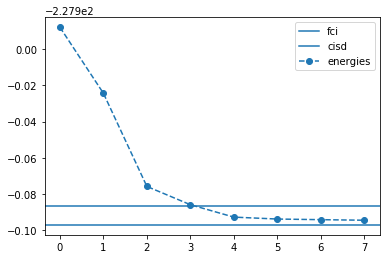

In [4]:
result.history.plot("energies", baselines={"fci":fci, "cisd": cisd}, filename="benzene_result_bfgs")